# Sample Functions for Analysis

In [1]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import nltk
from nltk.collocations import *

import networkx as nx
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Preparations

In [2]:
data = pd.read_pickle("data/data_normalized.pkl")

In [3]:
data = data[data['genre']=='twitter']
data.genre.unique()

array(['twitter'], dtype=object)

## Word/Phrase Frequency

In [4]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)

In [5]:
freq[:10]

,count
s,129686
say,49579
not,43936
people,36104
think,30924
go,28779
know,26218
year,25895
come,21912
time,21471


In [12]:
years = data['year'].unique()
years

array([1990, 1991, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       1996, 2013, 2014, 2015])

In [15]:
# get context

for yr in years:
    yearly = data[data['year']==yr]
    post_text = nltk.Text(yearly['tokenized_words'].sum())
    index = nltk.text.ConcordanceIndex(post_text) 
    print(yr)
    index.print_concordance('refugee', lines=10)
    index.print_concordance('refugees', lines=10)
    post_text.common_contexts(['refugees'])

1990
Displaying 10 of 130 matches:
university and himself a 1960 cuban refugee mariels were driven less by politic
he wall photo black white below the refugee center where the suarezes and other
toon at second glance i look like a refugee farmer but careful examination reve
s guerrillas as we pass a family of refugee indians from the highlands dressed 
ople creating a massive and complex refugee problem half a million saudis egypt
tuation is of particular concern to refugee organizations if baghdad succeeds i
 an unusual briefing on the kuwaiti refugee dilemma and the palestinian aspect 
at they had better shut down contra refugee camps before michael dukakis became
ndcutting why not the fanjuls are a refugee family he says the economy of the c
ttee on the panama canal the aid to refugee chinese intellectuals among the bet
Displaying 10 of 351 matches:
w in the water jammed with 80 or so refugees some of them just released from cub
torm a documentary about the mariel refugees fate as h

these_from fellow_build other_in reopened_have rwandan_primarily
populations_migrant help_1he rwandan_fought chinese_from
palestinian_and destitute_immediately and_from on_cbs on_havana
resulting_are palestine_unrwa registered_rooted with_and of_crowded
economic_from
1995
Displaying 10 of 84 matches:
d years of school while detained in refugee camps abroad do amazingly well in o
 me of a photograph i had seen of a refugee child in the ruins of a bombed vill
n was continuing bush s restrictive refugee policy and maintaining economic san
tion as an oblate arose from my own refugee experience as an exiled child livin
ungarian uprising and images of his refugee childhood is set in a virtual archi
d on battlefields in prisons and in refugee camps in other words in places of h
 of cambodians returning from their refugee camps in thailand have nt been able
al asylum then sit in a west german refugee camp for six months and finally set
the souls of everyone who was there refugee and reporter a

like_after park_a for_once them_but of_to of_is asserted_would arab_he
for_washington million_wandered for_fleeing azeri_in for_camps of_and
of_nor now_of war_and for_they with_other many_from
2001
Displaying 10 of 146 matches:
 national network for immigrant and refugee rights an alliance of more than 200
m and homophobia in immigration and refugee policy the national office provides
eng they spent six months in a thai refugee camp and were eventually sponsored 
whom had spent their whole lives in refugee camps the militants built madrasahs
untless times before throughout the refugee camps of pakistan s northwest front
ng those there to greet us were two refugee families who had fled the fighting 
eels like a philippe starckdesigned refugee camp the camera crews trailing the 
ent to at least one american dotcom refugee according to an article that recent
imate reward for taking in a french refugee fleeing civil war in her homelandan
rls an old friend and fellow german refugee scientis

for_and other_from the_end of_across as_were with_and were_from
incoming_the desperate_and somali_showed somali_from became_after
few_had for_like the_get the_there the_arrived the_but for_has
hurricane_in
2006
Displaying 10 of 120 matches:
f war and displacement she explains refugee women are vulnerable because rape a
who spent 13 years in pakistan as a refugee returning to kabul three years ago 
n to herself in the teeming darfuri refugee camp where most families must share
ling a foundation that supports the refugee camps by structurally raping women 
ow is going back to her family in a refugee camp she is afraid of what her pare
saving the world visiting an afghan refugee camp in pakistan she s why guys inv
enza preparedness and mitigation in refugee and displaced populations who guide
 outreach has turned caracas into a refugee camp for socialists displaced since
ng girls i also was in somalia at a refugee camp at a place called wajid home t
embers of his family in a tent at a ref

climate_people migrants_and political_and climate_will climate_needs
christian_to many_who encouraging_to nicaraguan_and real_who
persecuted_have the_scramble the_face zimbabwean_were the_in the_were
homeless_out the_hospitality with_it the_arrive
2011
Displaying 10 of 74 matches:
ould also do more to respond to the refugee crisis emerging from the conflict i
adations i wondered how i asked the refugee named emmanuel have you ever wonder
ity health centers 900 million from refugee programs and 390 million from lowin
rise has stepped james frey fig 2 a refugee from the great decade of american f
ct of landthink of it as a wildlife refugee camp in practice this does nt alway
r medical school into a traumatized refugee for almost ten years gbowee moved b
 trench warfare the tragedy of mass refugee migrations and the coldly impersona
 on everything from air defenses to refugee movements by the start of the 21st 
e south marion led a ragtag band of refugee continental soldiers into the camp

as_into million_thousands needs_and to_in with_and and_services
syrian_in of_grows for_is means_are cases_can syrian_teaching into_and
million_the kids_and and_from environmental_will moreover_from
zoroastrian_who making_of
2015
Displaying 10 of 210 matches:
ear the vatican visited a jesuitrun refugee shelter in rome and more recently s
in the mediterranean in the area of refugee protection francis focus on the syr
 and to help those who struggle for refugee protection to be maintained in our 
ope s focus on the syrian and iraqi refugee crisis one of the largest humanitar
e of catholic bishops migration and refugee services visited the middle east in
ith in china hosting a north korean refugee is illegal and this church had alre
nited states i arrived in 2007 as a refugee and began attending high school in 
ver meant all jews one man an iraqi refugee told me the jews have too much powe
n fact box adds he too is a climate refugee his daughter is three and a half an
esponded by setting u

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded " "(please install Tkinter library).")


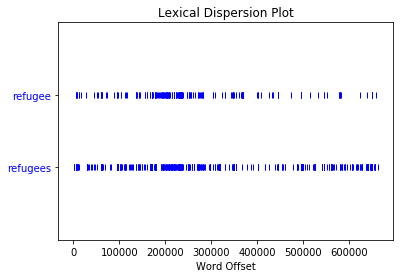

In [16]:
#Lexical Dispersion Plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
post_text.dispersion_plot(['refugee', 'refugees'])
sns.set() #Re-enabling seaborn

In [17]:
#Most common POS
def get_most_common_POS(data, years, genre=None):
    for yr in years:
        if genre:
            yearly = data[(data['genre']==genre) & (data['year']==yr)]
        else:
            yearly = data[data['year']==yr]
        freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in yearly['normalized_words_POS'].sum())
        print(yr)
        print("Most Common Nouns")
        print(freqdist_POStoWord['NN'].most_common(10))
        print()
        print("Most Common Adj")
        print(freqdist_POStoWord['JJ'].most_common(10))
        print()
        print("Most Common Verbs")
        print(freqdist_POStoWord['VB'].most_common(10))
        print()

In [18]:
years = sorted(data['year'].unique())
genres = data['genre'].unique()
genres

array(['MAG', 'SPOK', 'NEWS'], dtype=object)

In [19]:
get_most_common_POS(data, years)

1990
Most Common Nouns
[('time', 960), ('government', 933), ('today', 874), ('world', 786), ('country', 783), ('war', 689), ('way', 662), ('year', 565), ('mrlehrer', 535), ('day', 433)]

Most Common Adj
[('other', 1195), ('many', 821), ('new', 763), ('american', 621), ('last', 602), ('good', 571), ('iraqi', 564), ('military', 530), ('first', 495), ('soviet', 486)]

Most Common Verbs
[('be', 3592), ('have', 1320), ('do', 824), ('get', 708), ('go', 554), ('think', 488), ('take', 481), ('make', 479), ('say', 445), ('see', 404)]

1991
Most Common Nouns
[('war', 1339), ('time', 1246), ('government', 1092), ('today', 1072), ('country', 925), ('way', 892), ('world', 750), ('year', 657), ('mrlehrer', 578), ('day', 567)]

Most Common Adj
[('other', 1439), ('many', 1076), ('american', 835), ('iraqi', 834), ('new', 826), ('last', 811), ('good', 770), ('first', 673), ('political', 648), ('own', 568)]

Most Common Verbs
[('be', 4783), ('have', 1974), ('do', 1201), ('get', 883), ('go', 874), ('think

2006
Most Common Nouns
[('time', 721), ('world', 471), ('country', 459), ('government', 453), ('way', 448), ('day', 441), ('today', 417), ('war', 370), ('city', 370), ('family', 345)]

Most Common Adj
[('other', 669), ('many', 627), ('new', 571), ('last', 412), ('israeli', 387), ('first', 381), ('good', 329), ('american', 300), ('little', 281), ('own', 275)]

Most Common Verbs
[('be', 2129), ('have', 804), ('get', 545), ('do', 481), ('see', 397), ('go', 386), ('take', 366), ('make', 323), ('say', 254), ('come', 249)]

2007
Most Common Nouns
[('time', 521), ('war', 460), ('government', 414), ('world', 388), ('year', 342), ('country', 334), ('way', 331), ('today', 326), ('life', 304), ('day', 273)]

Most Common Adj
[('other', 491), ('many', 412), ('new', 389), ('last', 294), ('first', 268), ('american', 252), ('good', 243), ('political', 227), ('own', 214), ('few', 181)]

Most Common Verbs
[('be', 1633), ('have', 706), ('do', 460), ('get', 348), ('go', 287), ('make', 268), ('see', 255), 

In [20]:
# Word Cloud by year
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    if words==0:
        continue
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    wc.to_file('wordcloud/data_{}_All.png'.format(yr))
# nouns and sentiments

In [32]:
def get_nouns_and_adj(data):
    noun_adj = []
    for word, pos in data['normalized_words_POS'].sum():
        if pos.startswith('NN') or pos.startswith('JJ'):
            noun_adj.append(word)
    return noun_adj

In [33]:
for yr in years:
    yearly = data[data['year']==yr]
    words = get_nouns_and_adj(yearly)
    if len(words)==0:
        continue
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    wc.to_file('wordcloud/data_{}_Nouns_Adj.png'.format(yr))

In [34]:
# collocations
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    
    data_bigrams = nltk.collocations.BigramCollocationFinder.from_words(words)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    print(yr)
    print(data_bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:5])
    
    data_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(words)
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    print(data_trigrams.score_ngrams(trigram_measures.likelihood_ratio)[:5])
    
# other options include student_t, chi_sq, likelihood_ratio, pmi

1990
[(('unite', 'state'), 7242.095258047035), (('saddam', 'hussein'), 5070.514935596461), (('saudi', 'arabia'), 4574.108121239991), (('soviet', 'union'), 3964.4579606316947), (('khmer', 'rouge'), 3273.287562752811)]
[(('unite', 'state', 'baker'), 11150.260910882527), (('ambassador', 'unite', 'state'), 11130.192965367232), (('unite', 'state', 'soviet'), 10953.49391724261), (('unite', 'state', 'government'), 10935.590402072667), (('unite', 'state', 's'), 10925.819747032008)]
1991
[(('unite', 'state'), 8661.412428533353), (('saddam', 'hussein'), 7471.140858812556), (('soviet', 'union'), 4166.009223228741), (('new', 'york'), 3348.505297479314), (('abc', 'news'), 3267.0554730484187)]
[(('unite', 'state', 'baker'), 13268.918637990577), (('president', 'unite', 'state'), 13155.42015349009), (('unite', 'state', 'america'), 13075.725771298034), (('unite', 'state', 'israel'), 13070.265422139604), (('ambassador', 'unite', 'state'), 13068.338935056696)]
1992
[(('unite', 'state'), 4059.412346029798

[(('unite', 'state', 'department'), 3456.7115368284412), (('president', 'unite', 'state'), 3416.357657121476), (('unite', 'state', 'israel'), 3406.4733547908954), (('unite', 'state', 'senate'), 3333.2942364876817), (('immigrate', 'unite', 'state'), 3313.1803918062988)]
2008
[(('unite', 'state'), 1249.976903402724), (('new', 'york'), 1238.4738627993415), (('barack', 'obama'), 702.5223228466176), (('hillary', 'clinton'), 687.8775925689525), (('prime', 'minister'), 575.7596715031603)]
[(('new', 'york', 'city'), 1997.3861599581267), (('new', 'york', 'time'), 1960.970723017536), (('envirosell', 'new', 'york'), 1919.1296757540658), (('resettlement', 'unite', 'state'), 1912.6304030601918), (('part', 'unite', 'state'), 1912.2466070877922)]
2009
[(('mankiewicz', 'voiceover'), 1316.545801683965), (('unite', 'state'), 1115.315466432356), (('new', 'york'), 881.0794998700405), (('suu', 'kyi'), 682.729165119768), (('health', 'care'), 613.638030858527)]
[(('mankiewicz', 'voiceover', 'tom'), 2127.3129

## Calculating Divergence

In [14]:
# def kl_divergence(X, Y):
#     P = X.copy()
#     Q = Y.copy()
#     P.columns = ['P']
#     Q.columns = ['Q']
#     df = Q.join(P).fillna(0)
#     p = df.iloc[:,1]
#     q = df.iloc[:,0]
#     D_kl = scipy.stats.entropy(p, q)
#     return D_kl

# def chi2_divergence(X,Y):
#     P = X.copy()
#     Q = Y.copy()
#     P.columns = ['P']
#     Q.columns = ['Q']
#     df = Q.join(P).fillna(0)
#     p = df.iloc[:,1]
#     q = df.iloc[:,0]
#     return scipy.stats.chisquare(p, q).statistic

# def Divergence(corpus1, corpus2, difference="KL"):
#     """Difference parameter can equal KL, Chi2, or Wass"""
#     freqP = nltk.FreqDist(corpus1)
#     P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
#     freqQ = nltk.FreqDist(corpus2)
#     Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
#     if difference == "KL":
#         return kl_divergence(P, Q)
#     elif difference == "Chi2":
#         return chi2_divergence(P, Q)
#     elif difference == "KS":
#         try:
#             return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
#         except:
#             return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
#     elif difference == "Wasserstein":
#         try:
#             return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
#         except:
#             return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [15]:
# def plot_div_heatmap(corpora, fileids, diff_measure='KL'):
#     '''
#     Diff measure = KL, Chi2, KS or Wasserstein
#     '''
#     L = []
#     for p in corpora:
#         l = []
#         for q in corpora:
#             l.append(Divergence(p,q, difference = diff_measure))
#         L.append(l)
#     M = np.array(L)
#     fig = plt.figure()
#     div = pd.DataFrame(M, columns = fileids, index = fileids)
#     ax = sns.heatmap(div)
#     plt.show()

In [ ]:
# TO CHECK
#corpora = data['normalized_words'][:2].sum()
# corpora = []
# for index, row in data.iterrows():
#     corpora.append(row['tokenized_words'])
#fileids = list(data['text_id'][:2])
#plot_div_heatmap(corpora, fileids,diff_measure='KL')

## Word Networks

In [4]:
# def wordCooccurrence(sentences, makeMatrix = False):
#     words = set()
#     for sent in sentences:
#         words |= set(sent)
#     wordLst = list(words)
#     wordIndices = {w: i for i, w in enumerate(wordLst)}
#     wordCoCounts = {}
#     #consider a sparse matrix if memory becomes an issue
#     coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
#     for sent in sentences:
#         for i, word1 in enumerate(sent):
#             word1Index = wordIndices[word1]
#             for word2 in sent[i + 1:]:
#                 coOcMat[word1Index][wordIndices[word2]] += 1
#     if makeMatrix:
#         return coOcMat, wordLst
#     else:
#         coOcMat = coOcMat.T + coOcMat
#         g = nx.convert_matrix.from_numpy_matrix(coOcMat)
#         g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
#         return g

# def connected_component_subgraphs(G):
#     for c in nx.connected_components(G):
#         yield G.subgraph(c)

# def posCooccurrence(sentences, *posType, makeMatrix = False):
#     words = set()
#     reducedSents = []
#     #Only using the first kind of POS for each word
#     wordsMap = {}
#     for sent in sentences:
#         s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
#         for w, t in s:
#             if w not in wordsMap:
#                 wordsMap[w] = t
#         reducedSent = [w for w, t in s]
#         words |= set(reducedSent)
#         reducedSents.append(reducedSent)
#     wordLst = list(words)
#     wordIndices = {w: i for i, w in enumerate(wordLst)}
#     wordCoCounts = {}
#     #consider a sparse matrix if memory becomes an issue
#     coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
#     for sent in reducedSents:
#         for i, word1 in enumerate(sent):
#             word1Index = wordIndices[word1]
#             for word2 in sent[i + 1:]:
#                 coOcMat[word1Index][wordIndices[word2]] += 1
#     if makeMatrix:
#         return coOcMat, wordLst
#     else:
#         coOcMat = coOcMat.T + coOcMat
#         g = nx.convert_matrix.from_numpy_matrix(coOcMat)
#         g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
#         for w in g.nodes:
#             g.nodes[w]['bipartite'] = wordsMap[w]
#         return g

# def plot_word_graph(graph):
#     layout = nx.spring_layout(graph, weight='weight', iterations= 100)
#     fig, ax = plt.subplots(figsize = (10,10))
#     nx.draw(graph, ax = ax, pos = layout, labels = {n:n for n in graph.nodes()},
#             width=.2, 
#             alpha = .9, 
#             node_size = 100,
#             node_color = "xkcd:light red",
#             edge_color='xkcd:black')

# def plot_word_centrality(g):
#     layout_nn = nx.spring_layout(g, weight='weight', iterations= 100)
#     fig, ax = plt.subplots(figsize = (10,10))
#     centralities_nn = nx.eigenvector_centrality(g)
#     maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
#     #maxWeight = max((d['weight'] for n1, n2, d in g.edges(data = True)))
#     #minWeight = min((d['weight'] for n1, n2, d in g.edges(data = True)))
#     nx.draw(g, ax = ax, pos = layout_nn, labels = {n: n for n in g.nodes()},
#             #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
#             alpha = .9, 
#             node_color = [centralities_nn[n] / maxC for n in g.nodes],
#             node_size = [centralities_nn[n] / maxC * 100 for n in g.nodes],
#             font_size = 16,
#             font_color = 'xkcd:dark grey',
#             edge_color = 'xkcd:medium blue',
#             cmap = plt.get_cmap('plasma'),
#            )

### plot word network

In [ ]:
# plot word network
#g = wordCooccurrence(data['normalized_sents'].sum())
#len(g)

In [ ]:
# weight_choice = 25
# # remove if less than 25
# g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= weight_choice])
# #since we are changing the graph list() evaluates the isolates first
# g.remove_nodes_from(list(nx.isolates(g)))
# # keep just the giant connected component
# main_graph = max(connected_component_subgraphs(g), key=len)
# print(nx.info(main_graph))

In [ ]:
# plot_word_graph(main_graph)

In [ ]:
# # plot sub-graph
# immigrant_neighbors = main_graph.neighbors('family')
# subgraph_immigrant = main_graph.subgraph(immigrant_neighbors)
# print(nx.info(subgraph_immigrant))

# plot_word_graph(subgraph_immigrant)

In [ ]:
# # cliques
# print(', '.join(max(nx.clique.find_cliques(main_graph), key = lambda x: len(x))))

### plot word network by pos

In [ ]:
# # plot pos network
# gNV = posCooccurrence(data['normalized_sents'].sum(), 'NN', 'VB')
# print(nx.info(gNV))

In [ ]:
# degree_threshold= 100
# weight_threshold = 2
# gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= degree_threshold]) 
# print(nx.info(gNV))
# gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= weight_threshold])
# print(nx.info(gNV))

In [ ]:
# #TO CHECK
# plot_word_centrality(gNV)

In [ ]:
# # draw egocentric network
# g_immigrant_NV = gNV.subgraph(['family'] + list(gNV.neighbors('family')))
# print(nx.info(g_immigrant_NV))

In [ ]:
# nx.draw_networkx(g_immigrant_NV)

### centrality & global measures

In [ ]:
# #centralities

# centralities = nx.degree_centrality(main_graph)
# #centralities = nx.eigenvector_centrality(main_graph)
# #centralities = nx.closeness_centrality(main_graph)
# #centralities = nx.betweenness.betweenness_centrality(main_graph)
# plt.hist(list(centralities.values()))
# plt.show()

In [ ]:
# name = 'degree'

# centrality_df = pd.DataFrame.from_dict(centralities, orient='index', columns=[name])
# centrality_df.sort_values(by=name, ascending=False, inplace=True)
# #highest 10
# centrality_df[:10]

In [ ]:
# #global measures
# density = nx.density(main_graph)
# mean_degree_pernode = np.mean([v for w,v in nx.degree(main_graph)])
# diameter = nx.diameter(main_graph)
# print(
# "The density of this graph is {}\n\
# Mean degree per node is {}\n\
# Diameter of graph is {}".format(density, mean_degree_pernode, diameter))

## Clustering

In [3]:
# TFIDF vectoriser
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])

For 2 clusters, average silhouette score is 0.021088308321032177
For 3 clusters, average silhouette score is 0.01948034099746146
For 4 clusters, average silhouette score is 0.02073743099077297
For 5 clusters, average silhouette score is 0.023149696277986263
For 6 clusters, average silhouette score is 0.01981980218193442
For 7 clusters, average silhouette score is 0.025006490040207798
For 8 clusters, average silhouette score is 0.02924122660270278
For 9 clusters, average silhouette score is 0.03027735674778955


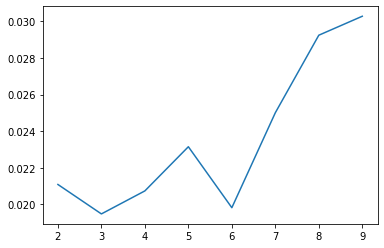

In [4]:
def find_best_n(X, max=10):
    clusters = []
    s_avg = []
    for i in range(2, max):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        clusters.append(i)
        s_avg.append(silhouette_avg)
        print("For {} clusters, average silhouette score is {}".format(i, silhouette_avg))
    plt.plot(clusters, s_avg)
    plt.show()

X = dataVects.toarray()
find_best_n(X)

In [5]:
num_cluster = 8
km = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')
km.fit(dataVects)
data['kmeans_prediction'] = km.labels_

In [6]:
def get_top_words(km, num_cluster, data_vectoriser):
    terms = data_vectoriser.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(num_cluster):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind])
        print('\n')

get_top_words(km, num_cluster, data_vectoriser)

Top terms per cluster:
Cluster 0:
 amp
 refugees
 refugee
 children
 syria
 syrian
 women
 help
 asylum
 people
 camps
 crisis
 new
 camp
 today
 migrants
 support
 need
 displaced
 rights


Cluster 1:
 refugee
 camps
 crisis
 children
 new
 world
 status
 day
 like
 agency
 help
 just
 asylum
 syria
 people
 canada
 women
 story
 says
 immigration


Cluster 2:
 iraqi
 iraq
 refugees
 refugee
 syria
 jordan
 iran
 baghdad
 crisis
 unhcr
 help
 million
 said
 iraqis
 war
 aid
 food
 says
 home
 new


Cluster 3:
 camp
 refugee
 palestinian
 lebanon
 syria
 refugees
 gaza
 syrian
 photo
 children
 army
 largest
 new
 people
 killed
 like
 israeli
 day
 jordan
 palestinians


Cluster 4:
 refugees
 syria
 people
 help
 unhcr
 new
 asylum
 world
 trump
 million
 home
 palestinian
 fleeing
 just
 children
 like
 border
 country
 today
 migrants


Cluster 5:
 nt
 said
 people
 says
 new
 think
 like
 just
 years
 time
 war
 know
 going
 did
 president
 government
 say
 world
 united
 mr


Clus

In [7]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    
    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")    
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


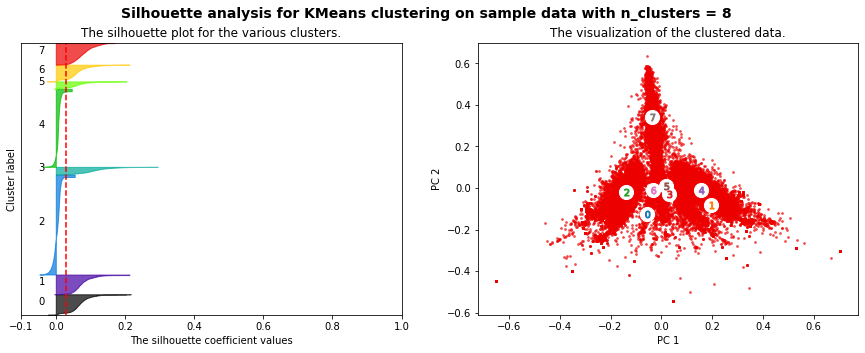

For n_clusters = 8, The average silhouette_score is : 0.029


In [8]:
plotSilhouette(num_cluster, X)

In [11]:
def plot_clusters(dataVects, km, num_cluster, terms=data_vectoriser.get_feature_names()):
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    # get distinguishing words to label
    components = pca.components_
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
    words = [terms[i] for i in keyword_ids]#Turn the ids into words.
    x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
    y = components[:,keyword_ids][1,:]
    
    cmap = matplotlib.cm.get_cmap("viridis")
    colors_p = [cmap(l/num_cluster) for l in km.labels_]
    
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))
    plt.xticks(())
    plt.yticks(())
    plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
    plt.show()

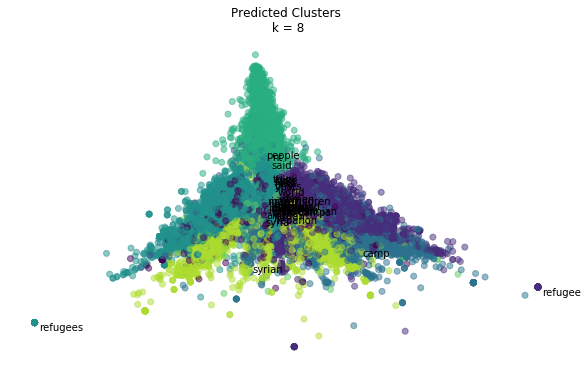

In [12]:
plot_clusters(dataVects, km, num_cluster)

## Topic Modelling

In [13]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [14]:
# creating dictionary
dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]
# serialize
gensim.corpora.MmCorpus.serialize('data.mm', corpus)
data_mm = gensim.corpora.MmCorpus('data.mm')
# topic modelling
topics=10
data_lda = gensim.models.ldamodel.LdaModel(corpus=data_mm, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')

In [19]:
data_lda.save("data_lda")

In [23]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:n][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title, n)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pd.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title, N):
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

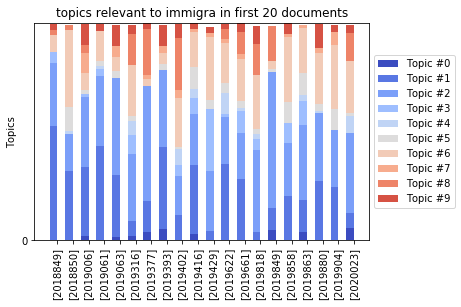

,text_id,title,year,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2018849,This is the land of opportunity.,1990,"[(1, 0.5253326), (2, 0.29182473), (3, 0.049467...",0.000000,0.525333,0.291825,0.049467,0.000000,0.000000,0.077423,0.000000,0.021908,0.031148
1,2018850,Betting on regional booms.,1990,"[(1, 0.32013375), (2, 0.1705646), (4, 0.011127...",0.000000,0.320134,0.170565,0.000000,0.011128,0.112707,0.353165,0.000000,0.022035,0.000000
2,2019006,The evolution of jeans.,1990,"[(0, 0.020056149), (1, 0.31573403), (2, 0.3244...",0.020056,0.315734,0.324465,0.014248,0.000000,0.016050,0.079405,0.093236,0.034292,0.097715
3,2019061,Serve the people.,1990,"[(1, 0.433052), (2, 0.32190588), (3, 0.0335600...",0.000000,0.433052,0.321906,0.033560,0.012989,0.021633,0.138060,0.000000,0.000000,0.032976
4,2019063,No road to Tahuanti.,1990,"[(0, 0.013729661), (1, 0.28623122), (2, 0.4451...",0.013730,0.286231,0.445102,0.000000,0.000000,0.035097,0.065493,0.047809,0.000000,0.098859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48988,1211780587104751617,NaN,2019,"[(1, 0.21721244), (2, 0.4369094), (3, 0.073148...",0.000000,0.217212,0.436909,0.073149,0.000000,0.079044,0.000000,0.000000,0.169668,0.000000
48989,1211776688796946433,NaN,2019,"[(1, 0.06812125), (2, 0.8774235)]",0.000000,0.068121,0.877424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48990,1211766973111123968,NaN,2019,"[(1, 0.23640421), (2, 0.6924678)]",0.000000,0.236404,0.692468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48991,1211758501384671232,NaN,2019,"[(1, 0.058954235), (2, 0.78261083), (9, 0.1063...",0.000000,0.058954,0.782611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106398


In [25]:
n=20
title = "topics relevant to immigra in first {} documents".format(n)
plot_topics(data_lda, dictionary, data, title, n=n)

In [32]:
for i in range(data_lda.num_topics):
    print(i)
    print(data_lda.show_topic(i, topn=10))

0
[('germany', 0.22856016), ('rt', 0.11632945), ('afghan', 0.08557863), ('pakistan', 0.0304707), ('car', 0.024698313), ('road', 0.023409158), ('necessary', 0.017915605), ('park', 0.015567685), ('say', 0.014850633), ('second', 0.011937427)]
1
[('child', 0.07768689), ('refugee', 0.042045552), ('year', 0.039433867), ('family', 0.038635504), ('woman', 0.025444224), ('amp', 0.019832328), ('care', 0.017876063), ('school', 0.016327385), ('immigration', 0.01614182), ('community', 0.014536445)]
2
[('refugee', 0.21005954), ('amp', 0.022319108), ('syrian', 0.020367691), ('camp', 0.017445033), ('people', 0.016648902), ('country', 0.014674869), ('help', 0.011321003), ('right', 0.010514403), ('world', 0.0097528035), ('syria', 0.009571345)]
3
[('trump', 0.21694729), ('vote', 0.06052036), ('administration', 0.046995383), ('president', 0.042855576), ('obama', 0.041589543), ('white', 0.029156314), ('america', 0.023967758), ('muslim', 0.023902135), ('state', 0.015444435), ('say', 0.015199301)]
4
[('asylu

In [ ]:
#dynamic topic modelling - long run time (overnight)
docs_per_year = list(data.groupby('year').size())
num_topics = 4
data_ldaseq = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

In [ ]:
data_ldaseq.save("data_ldaseq")

In [ ]:
data_ldaseq.print_topics(time=0)

In [38]:
#topic distribution divergence
from gensim.matutils import kullback_leibler

def plot_topic_divergence(data, years, num_topics=5):
    topic_prob, lda = get_topic_prob(data, years, num_topics)
    L = []
    for year_1 in topic_prob.keys():
        p = topic_prob[year_1]
        l = []
        for year_2 in topic_prob.keys():
            q = topic_prob[year_2]
            l.append(kullback_leibler(p, q))
        L.append(l)
    M = np.array(L)

    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(topic_prob.keys()), index = list(topic_prob.keys()))
    ax = sns.heatmap(div)
    plt.show()
    return lda
    
def get_topic_prob(data, years, num_topics=5):
    topic_prob = {}
    
    byyear, lda = get_topic_distribution(data, years, num_topics)
    # Convert to probability
    for yr in years:
        j=0
        for i in range(10):
            try:
                index, prob = byyear[yr][j]
            except IndexError:
                index = False

            if index == i:
                j+=1
                if yr in topic_prob:  
                    topic_prob[yr].append(prob)
                else:
                    topic_prob[yr] = [prob]
            else:
                if yr in topic_prob:  
                    topic_prob[yr].append(float(0))
                else:
                    topic_prob[yr] = [float(0)]
    return topic_prob, lda


def get_topic_distribution(data, years, num_topics=5):
    byyear = {}
    lda = {}
    # Get topic distribution for each year
    for yr in years:
        # get all text for each year
        text_df = data[data['year']==yr][['text']]
        text_df['tokenized_text'] = text_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
        text_df['normalized_tokens'] = text_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
        # create dictionary
        data_dictionary_byyear = gensim.corpora.Dictionary(text_df['normalized_tokens'])
        data_corpus_byyear = [data_dictionary_byyear.doc2bow(text) for text in text_df['normalized_tokens']]
        #lda
        lda_byyear = gensim.models.ldamodel.LdaModel(corpus=data_corpus_byyear, id2word=data_dictionary_byyear, num_topics=num_topics, alpha='auto', eta='auto')

        # place topic distribution in dictionary
        all_text = []
        for text in text_df['normalized_tokens']:
            all_text.extend(text)
        byyear[yr] = lda_byyear[data_dictionary_byyear.doc2bow(all_text)]
        lda[yr] = lda_byyear

        print('{} done'.format(yr))
    return byyear, lda

1990 done
1991 done
1992 done
1993 done
1994 done
1995 done
1996 done
1997 done
1998 done
1999 done
2000 done
2001 done
2002 done
2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done
2016 done
2017 done
2018 done
2019 done


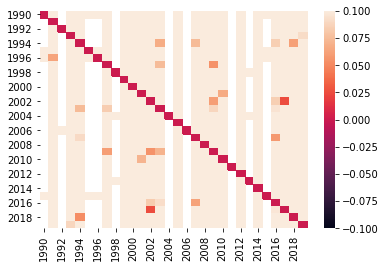

In [39]:
years = sorted(data['year'].unique())
lda_by_year = plot_topic_divergence(data, years, num_topics=5)
# think about how to use this for dynamic modelling

In [48]:
for yr in years:
    for i in range(5):
        print("Year: {}, Topic: {}".format(yr, i))
        print(lda_by_year[yr].show_topic(i, topn=10))

Year: 1990, Topic: 0
[('s', 0.017840486), ('not', 0.006985973), ('say', 0.006908972), ('think', 0.0066081136), ('people', 0.0062118117), ('go', 0.0049267206), ('year', 0.003969802), ('come', 0.0036370745), ('new', 0.0036005825), ('state', 0.0035364018)]
Year: 1990, Topic: 1
[('s', 0.021407982), ('not', 0.007896205), ('think', 0.0076712044), ('people', 0.005791726), ('mr', 0.0054905703), ('say', 0.0051753568), ('time', 0.0046452773), ('come', 0.0045770695), ('state', 0.004548571), ('year', 0.004498599)]
Year: 1990, Topic: 2
[('s', 0.019967554), ('say', 0.008148643), ('not', 0.0069843787), ('think', 0.006402402), ('people', 0.005672543), ('state', 0.004949473), ('year', 0.0044712457), ('country', 0.004032277), ('go', 0.0040151463), ('mr', 0.003925208)]
Year: 1990, Topic: 3
[('s', 0.01438683), ('say', 0.0075283726), ('think', 0.006533732), ('people', 0.0058847726), ('go', 0.005792419), ('not', 0.00568574), ('kuwait', 0.0039714817), ('country', 0.0039019762), ('world', 0.003696194), ('stat

## Word Embeddings

### word2vec

In [49]:
data_w2v = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum())

In [50]:
data_w2v.save('data_w2v')

In [3]:
data_w2v = gensim.models.word2vec.Word2Vec.load('data_w2v')

In [6]:
data_w2v.most_similar(positive=['refugee'])
#&amp, rt

[('migrant', 0.6012977957725525),
 ('amp', 0.5887587070465088),
 ('haitians', 0.5604172348976135),
 ('somalis', 0.5538501739501953),
 ('rt', 0.5495731830596924),
 ('ppl', 0.5322973728179932),
 ('syrians', 0.5321687459945679),
 ('asylumseekers', 0.5292373895645142),
 ('bangladesh', 0.5288541316986084),
 ('returnee', 0.5232784152030945)]

In [11]:
data_w2v.most_similar(positive=['asylumseekers'])

[('migrant', 0.7603486776351929),
 ('deportation', 0.7543079853057861),
 ('repatriate', 0.7517817616462708),
 ('malaysia', 0.7434117794036865),
 ('sweden', 0.7328014373779297),
 ('detention', 0.7102818489074707),
 ('deport', 0.7089986801147461),
 ('visa', 0.7036485075950623),
 ('cubans', 0.7000539302825928),
 ('deportee', 0.6948468685150146)]

In [12]:
data_w2v.similarity('refugee','asylumseekers')

0.5292374

In [4]:
data_w2v.most_similar(positive=['refugee', 'illegal'], negative=['legal'])

[('somalis', 0.5950162410736084),
 ('migrant', 0.5657041072845459),
 ('illegally', 0.538986325263977),
 ('thousand', 0.5281550288200378),
 ('foreigner', 0.5270982980728149),
 ('ppl', 0.5215610265731812),
 ('syrians', 0.5181779861450195),
 ('mexicans', 0.5131580829620361),
 ('albanians', 0.5106081962585449),
 ('ten', 0.5056760311126709)]

In [7]:
data_w2v.most_similar(positive=['refugee', 'independent'], negative=['dependent'])

[('geneva', 0.475247323513031),
 ('womens', 0.46584540605545044),
 ('formally', 0.45916178822517395),
 ('humanrights', 0.44805359840393066),
 ('blogs', 0.43602848052978516),
 ('blog', 0.43511295318603516),
 ('activist', 0.4338771104812622),
 ('delegate', 0.4299347400665283),
 ('wikileaks', 0.42497578263282776),
 ('convention', 0.4230250120162964)]

In [7]:
data_w2v.similarity('refugee','help')

0.29370317

In [9]:
data_w2v.similarity('refugee','crisis')

0.20419632

In [15]:
def plot_embeddings(data_w2v, numWords, save=False, title=''):
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    if save:
        fig.savefig("embeddingplot/{}".format(title), format='png')

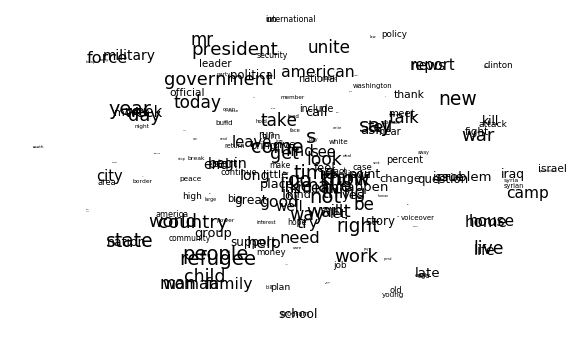

In [30]:
plot_embeddings(data_w2v, 200)

In [16]:
years=sorted(data['year'].unique())

1990
[('oil', 0.9792410731315613), ('camp', 0.9768356084823608), ('include', 0.9744404554367065), ('air', 0.9714218378067017), ('arm', 0.9707190990447998), ('border', 0.9701213836669922), ('ship', 0.9693930149078369), ('soldier', 0.9691706895828247), ('trickle', 0.9689023494720459), ('german', 0.9686344861984253)]


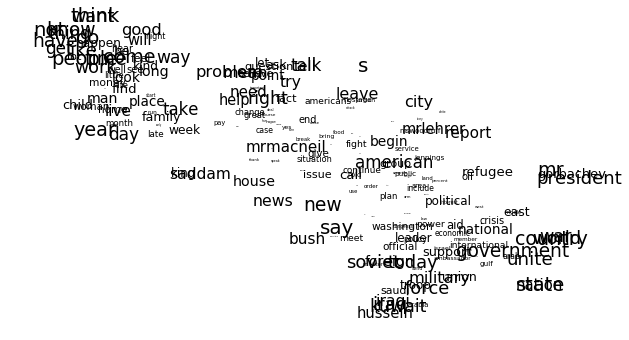

1991
[('camp', 0.9432388544082642), ('border', 0.9423507452011108), ('area', 0.9272516965866089), ('kurdish', 0.9108014702796936), ('northern', 0.8963286876678467), ('soldier', 0.8893006443977356), ('flee', 0.8873463273048401), ('return', 0.8837928771972656), ('southern', 0.8769162893295288), ('control', 0.8699886798858643)]


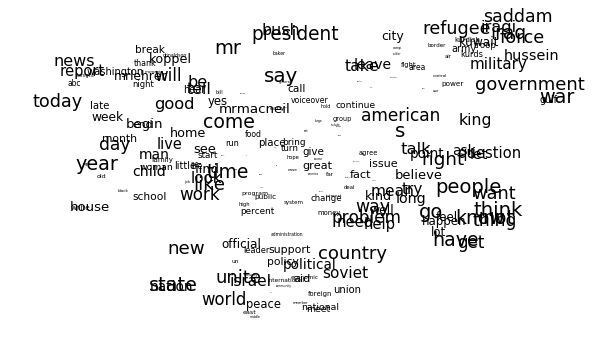

1992
[('country', 0.9887719750404358), ('force', 0.9883242249488831), ('war', 0.9860662221908569), ('un', 0.985877275466919), ('relief', 0.9834293127059937), ('international', 0.9826656579971313), ('european', 0.9825412034988403), ('government', 0.979178786277771), ('somalia', 0.9788316488265991), ('security', 0.978753387928009)]


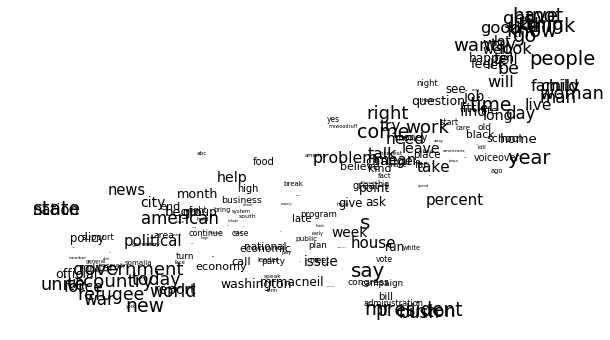

1993
[('un', 0.9910005331039429), ('government', 0.9903290867805481), ('force', 0.9888219833374023), ('bosnia', 0.9869241714477539), ('bosnian', 0.9864435195922852), ('security', 0.984635591506958), ('international', 0.9842423796653748), ('official', 0.9801943302154541), ('serbian', 0.9797613024711609), ('council', 0.979184627532959)]


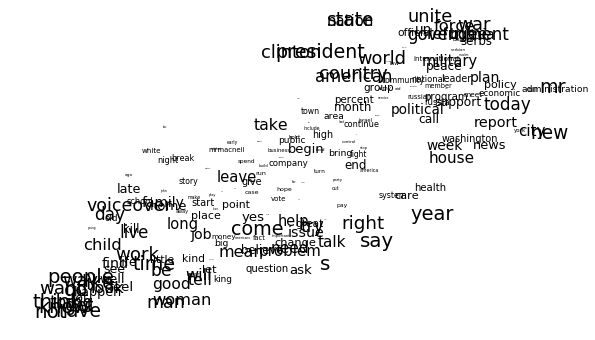

1994
[('war', 0.9422804117202759), ('troop', 0.9384253621101379), ('force', 0.9271855354309082), ('north', 0.9193631410598755), ('un', 0.9193053841590881), ('bosnian', 0.9184890389442444), ('air', 0.9182679057121277), ('power', 0.9050478935241699), ('police', 0.9030008912086487), ('cuban', 0.9017713069915771)]


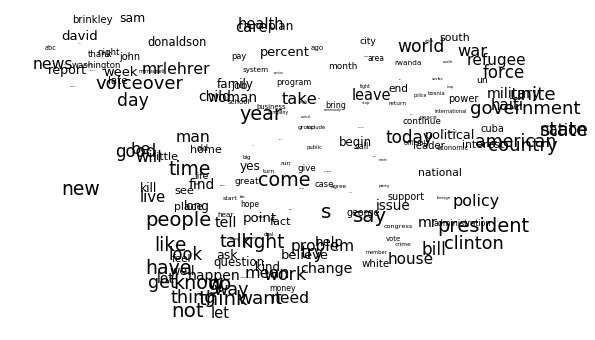

1995
[('area', 0.9994057416915894), ('croatia', 0.9992902874946594), ('srebrenica', 0.999279260635376), ('region', 0.9992517828941345), ('croat', 0.9992319345474243), ('army', 0.9992285370826721), ('embargo', 0.9991853833198547), ('defend', 0.999178946018219), ('commander', 0.9991353154182434), ('relief', 0.999125599861145)]


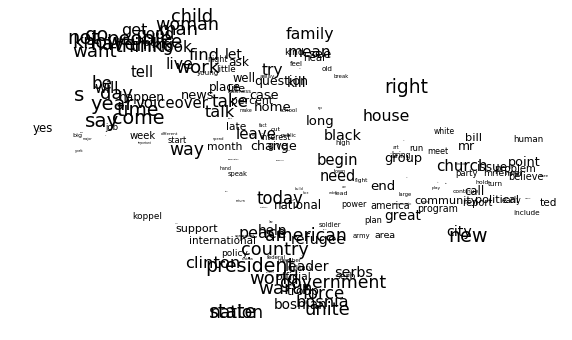

1996
[('force', 0.9913524389266968), ('military', 0.9912799000740051), ('camp', 0.9901483058929443), ('war', 0.9895673990249634), ('zaire', 0.9885740876197815), ('hutu', 0.9867715835571289), ('rwanda', 0.9861053824424744), ('government', 0.9856207370758057), ('official', 0.984542191028595), ('israel', 0.9838486909866333)]


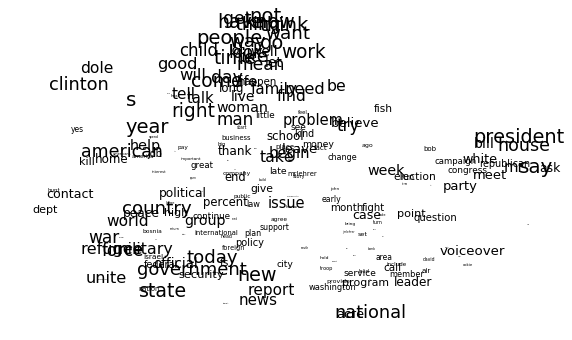

1997
[('attack', 0.9998466968536377), ('return', 0.999836802482605), ('kill', 0.9998360872268677), ('hutu', 0.999835193157196), ('die', 0.999832034111023), ('offer', 0.9998319745063782), ('troop', 0.9998294711112976), ('turkish', 0.9998288154602051), ('able', 0.9998264312744141), ('turkey', 0.9998257160186768)]


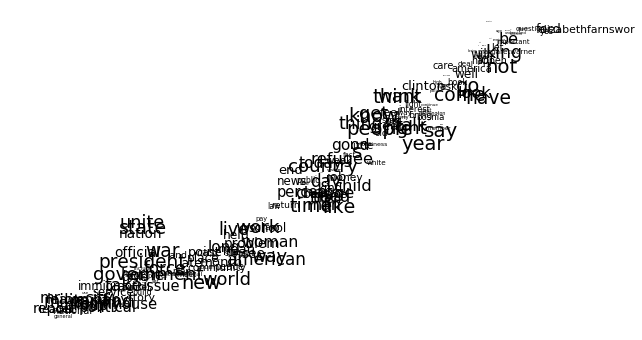

1998
[('land', 0.9998868107795715), ('return', 0.9998838901519775), ('kosovo', 0.9998832941055298), ('fight', 0.9998773336410522), ('lead', 0.9998772144317627), ('region', 0.9998763799667358), ('army', 0.9998729228973389), ('create', 0.9998711347579956), ('run', 0.9998683929443359), ('die', 0.9998672604560852)]


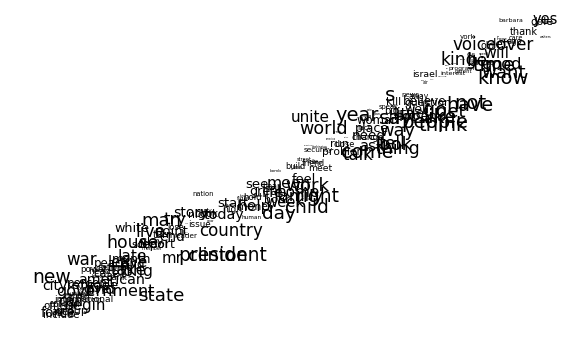

1999
[('albanian', 0.9910779595375061), ('ethnic', 0.9903970956802368), ('albanians', 0.9903779029846191), ('cleanse', 0.9894282221794128), ('flee', 0.9888797998428345), ('macedonia', 0.9875688552856445), ('serbs', 0.987544059753418), ('serb', 0.9872846603393555), ('army', 0.9872118830680847), ('police', 0.9860456585884094)]


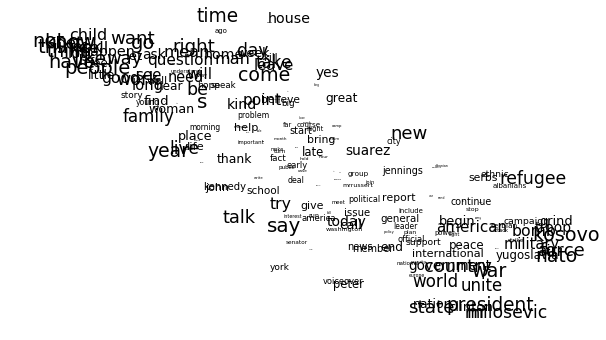

2000
[('return', 0.9984657764434814), ('camp', 0.9983428120613098), ('authority', 0.9980675578117371), ('thousand', 0.9980612993240356), ('force', 0.9980258941650391), ('leader', 0.9979605674743652), ('country', 0.9979031085968018), ('border', 0.9979028701782227), ('official', 0.9978667497634888), ('palestinians', 0.9978662729263306)]


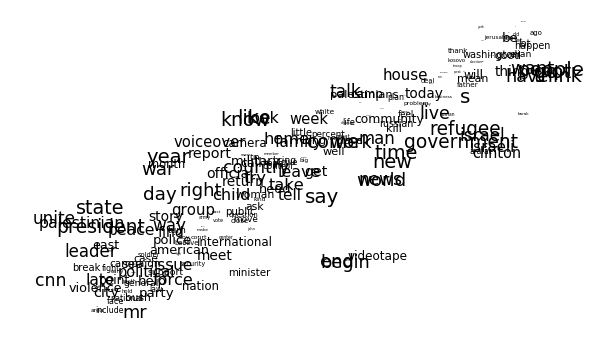

2001
[('afghan', 0.9982665181159973), ('troop', 0.9981827735900879), ('kabul', 0.998145580291748), ('flee', 0.9979416131973267), ('control', 0.9978837966918945), ('commander', 0.9977458715438843), ('civilian', 0.9977397918701172), ('capital', 0.9976806640625), ('palestinian', 0.9976603984832764), ('south', 0.9976004362106323)]


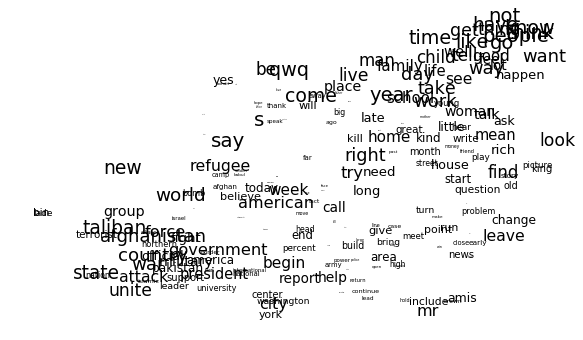

2002
[('jenin', 0.9740743637084961), ('camp', 0.9713238477706909), ('qalqilya', 0.9515050053596497), ('gaza', 0.9507975578308105), ('shamshatoo', 0.9482671022415161), ('strip', 0.9467177391052246), ('kill', 0.9436890482902527), ('israeli', 0.9422005414962769), ('nablus', 0.9412179589271545), ('force', 0.9410583972930908)]


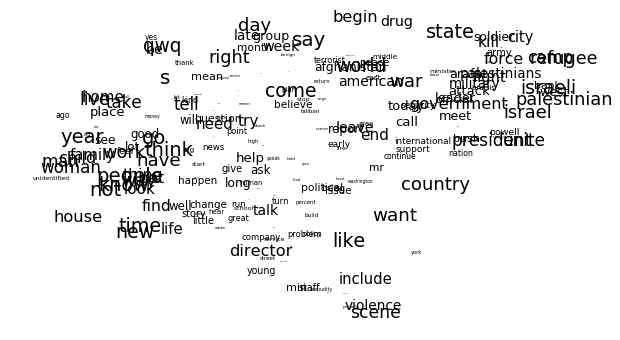

2003
[('return', 0.9996058344841003), ('un', 0.9996041655540466), ('israeli', 0.9995810389518738), ('aid', 0.9995647668838501), ('organization', 0.9995439052581787), ('humanitarian', 0.9995424151420593), ('northern', 0.999535322189331), ('official', 0.9995314478874207), ('border', 0.9995270371437073), ('army', 0.9995265007019043)]


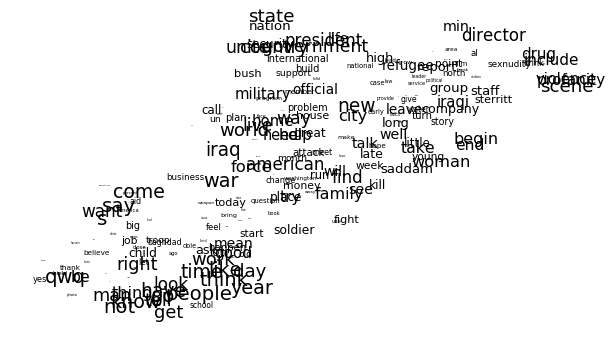

2004
[('government', 0.9994950294494629), ('camp', 0.9994629621505737), ('return', 0.9994481801986694), ('israel', 0.9994286298751831), ('official', 0.9994196891784668), ('country', 0.9994123578071594), ('hmong', 0.9994016885757446), ('neighbor', 0.9993994235992432), ('force', 0.9993875026702881), ('month', 0.9993866086006165)]


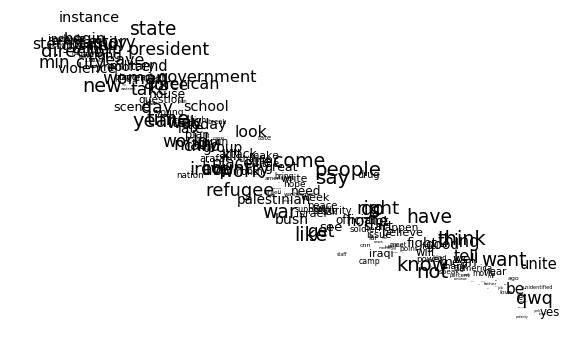

2005
[('small', 0.9997422099113464), ('return', 0.9997358322143555), ('hill', 0.9997315406799316), ('nearly', 0.9997289776802063), ('author', 0.9997240304946899), ('past', 0.9997191429138184), ('struggle', 0.9997177720069885), ('hundred', 0.9997124671936035), ('helicopter', 0.9997114539146423), ('phone', 0.9997105598449707)]


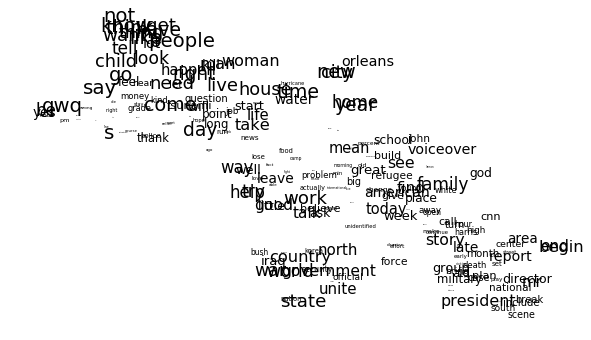

2006
[('threat', 0.9991653561592102), ('leader', 0.9991539716720581), ('hill', 0.9991121292114258), ('asia', 0.9990847706794739), ('visit', 0.9990694522857666), ('impose', 0.9990355968475342), ('flee', 0.9990269541740417), ('capability', 0.9990212917327881), ('intelligence', 0.9990192651748657), ('un', 0.9990154504776001)]


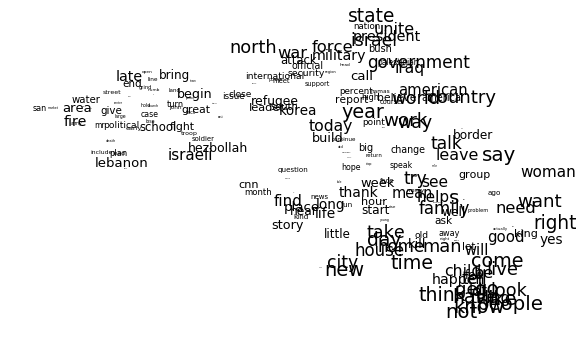

2007
[('palestinian', 0.9985389113426208), ('lebanon', 0.9984561204910278), ('government', 0.9975793957710266), ('palestinians', 0.9975253939628601), ('iraq', 0.9975101947784424), ('iraqi', 0.9972565174102783), ('force', 0.9972327947616577), ('israel', 0.9970905780792236), ('militant', 0.9969003200531006), ('arab', 0.9968848824501038)]


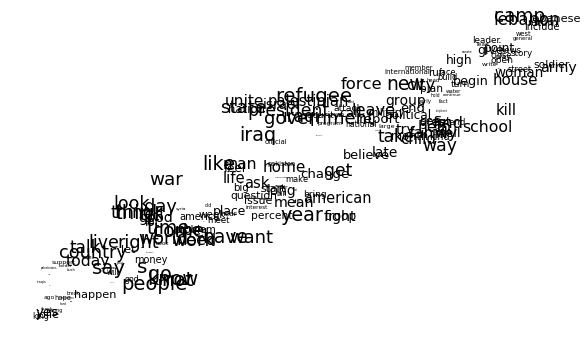

2008
[('palestinian', 0.9996587038040161), ('force', 0.9996554851531982), ('lebanon', 0.9996527433395386), ('return', 0.999644935131073), ('chad', 0.9996375441551208), ('neighbor', 0.9996351599693298), ('kosovo', 0.9996315240859985), ('month', 0.999630868434906), ('bomb', 0.9996273517608643), ('military', 0.9996259212493896)]


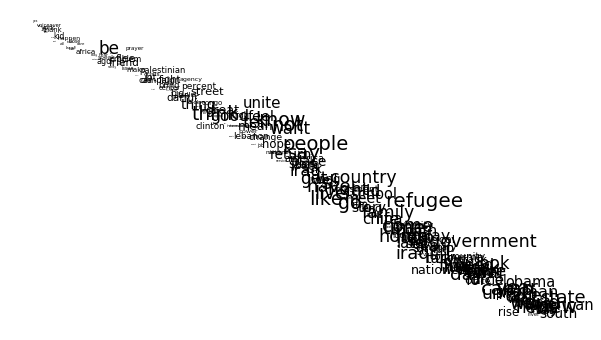

2009
[('chad', 0.9994152188301086), ('neighbor', 0.999413788318634), ('century', 0.9993923902511597), ('washington', 0.9993624091148376), ('news', 0.9993586540222168), ('rt', 0.9993572235107422), ('give', 0.9993489980697632), ('early', 0.9993479251861572), ('blog', 0.9993476867675781), ('return', 0.9993459582328796)]


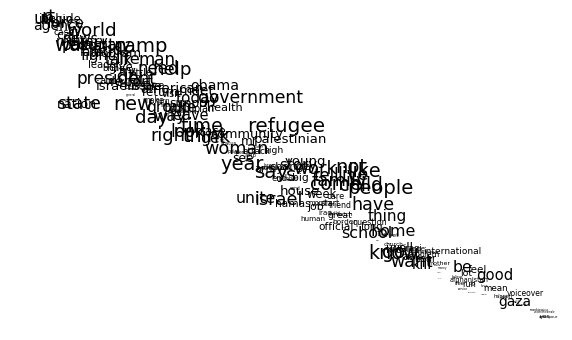

2010
[('land', 0.9995391368865967), ('hard', 0.9995332360267639), ('situation', 0.9995194673538208), ('force', 0.9995191693305969), ('use', 0.9995176792144775), ('finally', 0.9995150566101074), ('haiti', 0.9995083808898926), ('work', 0.9995070695877075), ('place', 0.9995054006576538), ('well', 0.9995032548904419)]


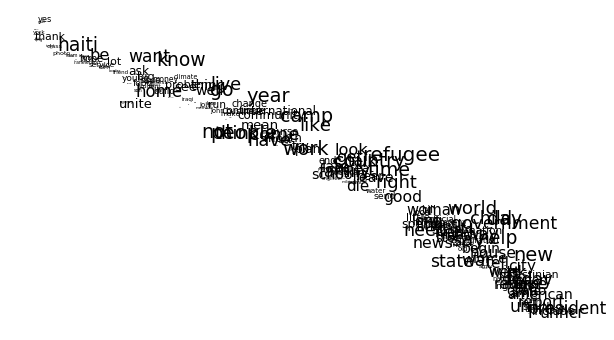

2011
[('kenya', 0.9992508888244629), ('dadaab', 0.9991024732589722), ('large', 0.999100923538208), ('somalia', 0.9990655779838562), ('bomb', 0.9990159869194031), ('turkish', 0.999003529548645), ('wfp', 0.9989938139915466), ('northern', 0.9989854693412781), ('famine', 0.9989768266677856), ('liberia', 0.9989705681800842)]


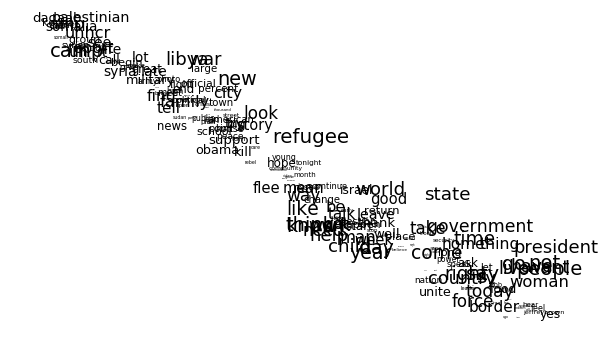

2012
[('turkey', 0.9955490827560425), ('border', 0.994997501373291), ('syria', 0.9948680996894836), ('force', 0.9943455457687378), ('lebanon', 0.9940264225006104), ('flee', 0.994008481502533), ('jordan', 0.9936912655830383), ('turkish', 0.9935919046401978), ('rebel', 0.9933485388755798), ('army', 0.993324875831604)]


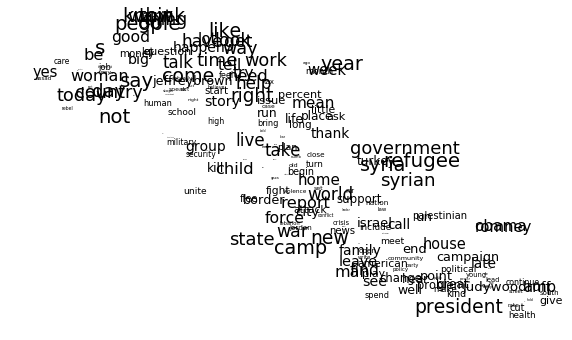

2013
[('child', 0.9908180832862854), ('jordan', 0.9905539751052856), ('camp', 0.9876464605331421), ('lebanon', 0.98661208152771), ('syrian', 0.985914945602417), ('syria', 0.9857649207115173), ('zaatari', 0.9852020740509033), ('live', 0.9841549396514893), ('border', 0.9830315113067627), ('flee', 0.9830049276351929)]


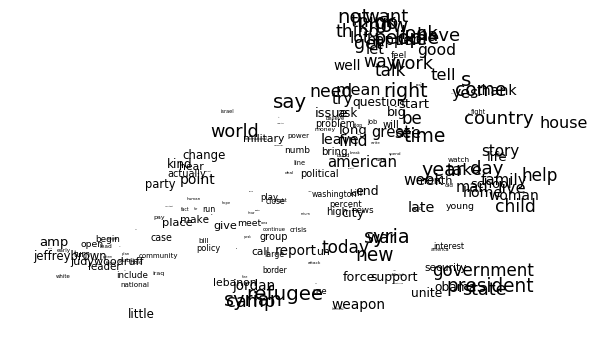

2014
[('syrian', 0.9550772905349731), ('force', 0.9527289271354675), ('camp', 0.9525525569915771), ('border', 0.9458270072937012), ('syria', 0.9439089298248291), ('flee', 0.9408100247383118), ('jordan', 0.9392517805099487), ('war', 0.9284305572509766), ('iraqi', 0.9274280071258545), ('isis', 0.9264659285545349)]


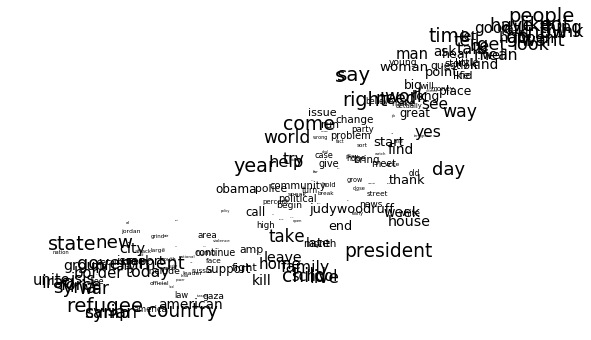

2015
[('camp', 0.9455358386039734), ('migrant', 0.936455249786377), ('flee', 0.924287736415863), ('border', 0.9202296137809753), ('crisis', 0.918533444404602), ('syrian', 0.9153925180435181), ('thousand', 0.914774477481842), ('europe', 0.9136730432510376), ('report', 0.9136378169059753), ('war', 0.913408637046814)]


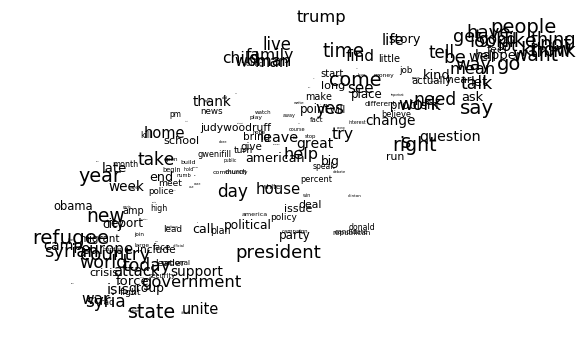

2016
[('amp', 0.9999464750289917), ('not', 0.9999364614486694), ('crisis', 0.9999332427978516), ('syria', 0.9999323487281799), ('syrian', 0.999931812286377), ('camp', 0.9999293684959412), ('say', 0.9999289512634277), ('help', 0.9999289512634277), ('world', 0.9999285936355591), ('greece', 0.9999269247055054)]


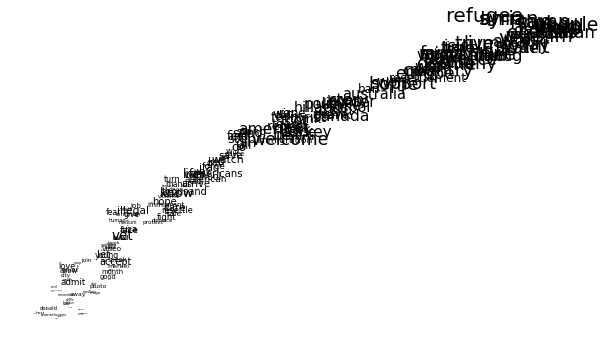

2017
[('amp', 0.9999418258666992), ('work', 0.9999417662620544), ('s', 0.999940037727356), ('not', 0.9999395608901978), ('world', 0.9999372959136963), ('crisis', 0.999934196472168), ('syria', 0.9999334216117859), ('year', 0.9999332427978516), ('country', 0.9999326467514038), ('syrian', 0.9999321699142456)]


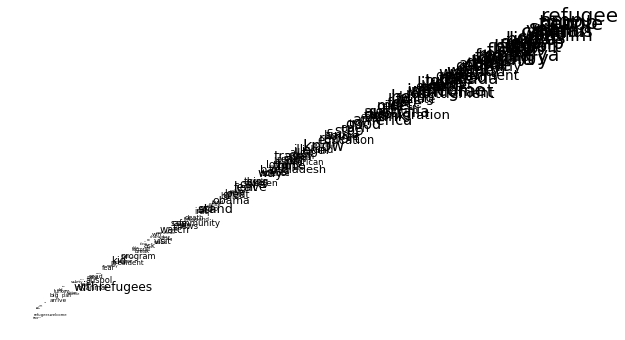

2018
[('support', 0.9999219179153442), ('create', 0.9999197721481323), ('work', 0.9999176263809204), ('amp', 0.9999164938926697), ('world', 0.999916136264801), ('help', 0.9999154210090637), ('canada', 0.9999123811721802), ('crisis', 0.9999114871025085), ('force', 0.9999113082885742), ('home', 0.999910295009613)]


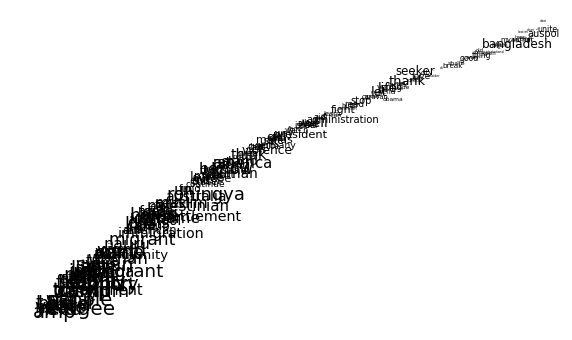

2019
[('syria', 0.9999163150787354), ('work', 0.9999128580093384), ('family', 0.9999100565910339), ('thank', 0.9999092817306519), ('attack', 0.9999064207077026), ('world', 0.9999061822891235), ('amp', 0.9999054670333862), ('give', 0.9999012351036072), ('today', 0.9999005794525146), ('canada', 0.9999004602432251)]


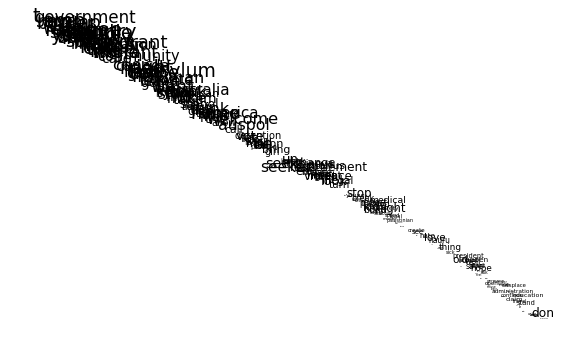

In [17]:
# Year on year
yearly_w2v = {}
for yr in years:
    yearly = data[data['year']==yr]
    data_w2v = gensim.models.word2vec.Word2Vec(yearly['normalized_sents'].sum())
    yearly_w2v[yr] = data_w2v
    print(yr)
    print(data_w2v.most_similar(positive=['refugee']))
    plot_embeddings(data_w2v, 200, save=True, title='{}.png'.format(yr))

In [33]:
yearly_w2v

{1990: <gensim.models.word2vec.Word2Vec at 0x10b1a6c40>,
 1991: <gensim.models.word2vec.Word2Vec at 0x14ababeb0>,
 1992: <gensim.models.word2vec.Word2Vec at 0x14aa41400>,
 1993: <gensim.models.word2vec.Word2Vec at 0x149cfe3d0>,
 1994: <gensim.models.word2vec.Word2Vec at 0x149abddf0>,
 1995: <gensim.models.word2vec.Word2Vec at 0x1467be430>,
 1996: <gensim.models.word2vec.Word2Vec at 0x149cfe520>,
 1997: <gensim.models.word2vec.Word2Vec at 0x148917f40>,
 1998: <gensim.models.word2vec.Word2Vec at 0x151a0e5b0>,
 1999: <gensim.models.word2vec.Word2Vec at 0x1519fd370>,
 2000: <gensim.models.word2vec.Word2Vec at 0x18ae7d580>,
 2001: <gensim.models.word2vec.Word2Vec at 0x148917250>,
 2002: <gensim.models.word2vec.Word2Vec at 0x284a38a30>,
 2003: <gensim.models.word2vec.Word2Vec at 0x1484e3b20>,
 2004: <gensim.models.word2vec.Word2Vec at 0x28a89cbe0>,
 2005: <gensim.models.word2vec.Word2Vec at 0x28bc29400>,
 2006: <gensim.models.word2vec.Word2Vec at 0x28a89c8e0>,
 2007: <gensim.models.word2vec.

### doc2vec

In [11]:
# def tag_docs(data):
#     taggedDocs = []
#     for index, row in data.iterrows():
#         #Just doing a simple keyword assignment
#         docKeywords = [row['year']]
#         docKeywords.append(row['text_id'])
#         docKeywords.append(row['genre'])
#         docKeywords.append(row['word_count'])
#         taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
#     return taggedDocs

# data['tagged_docs'] = tag_docs(data)

In [ ]:
# memory error
#data_d2v = gensim.models.doc2vec.Doc2Vec(data['tagged_docs'],vector_size=100)

In [ ]:
# data_d2v.save("data_d2v")

In [ ]:
# data_d2v.most_similar(positive = ['immigrants','illegal'], negative = ['legal'], topn = 10)

In [ ]:
# def most_similar_by_year(data_d2v,years):
#     for yr in years:
#         print(yr)
#         print(data_d2v.most_similar( [ data_d2v.docvecs[yr] ], topn=5))
#         print()

# years = range(1990,2016)        
# most_similar_by_year(data_d2v, years)

In [ ]:
# genre = list(data['genre'].unique())       
# most_similar_by_year(data_d2v, genre)

In [ ]:
# def plot_similarity(data_d2v, targetDocs):
#     heatmapMatrixD = []
#     for tagOuter in targetDocs:
#         column = []
#         tagVec = data_d2v.docvecs[tagOuter].reshape(1, -1)
#         for tagInner in targetDocs:
#             column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, data_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
#         heatmapMatrixD.append(column)
#     heatmapMatrixD = np.array(heatmapMatrixD)
#     fig, ax = plt.subplots()
#     hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
#     cbar = plt.colorbar(hmap)

#     cbar.set_label('cosine similarity', rotation=270)
#     a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
#     a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

#     a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
#     a = ax.set_yticklabels(targetDocs, minor=False)

In [ ]:
# plot_similarity(data_d2v, list(data['year'].unique()))

In [ ]:
# plot_similarity(data_d2v, list(data['genre'].unique()))

### change over time

In [9]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [10]:
data_rawEmbeddings, data_comparedEmbeddings = compareModels(data, 'year')

In [11]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

def plot_divergence(targetWord, comparedEmbeddings):
    pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
    fig, ax = plt.subplots(figsize = (10, 7))
    sns.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
    ax.set_xlabel("Starting year")
    ax.set_ylabel("Final year")
    ax.set_ylabel("Final year")
    ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
    plt.show()

refugee


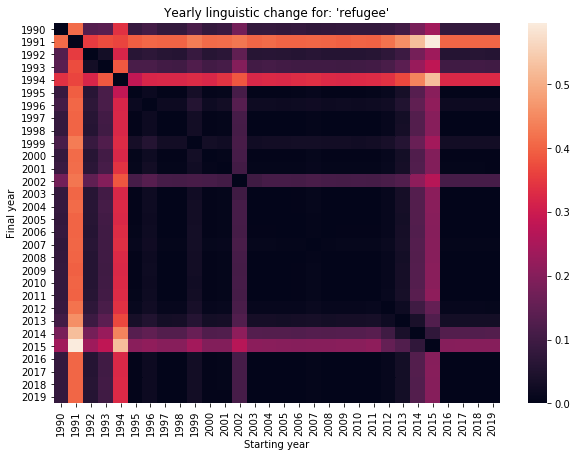

In [20]:
plot_divergence('refugee', data_comparedEmbeddings)

border


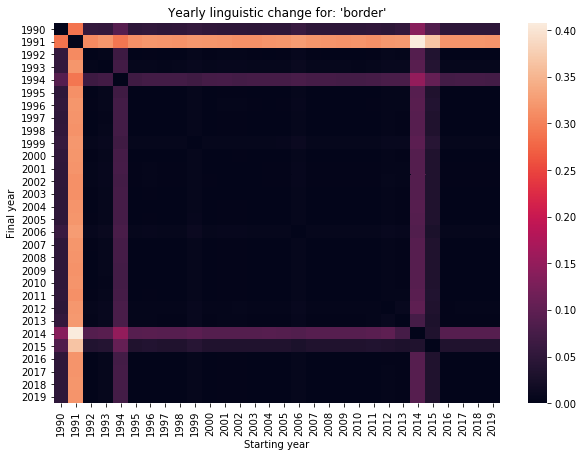

In [26]:
plot_divergence('border', data_comparedEmbeddings)

crisis


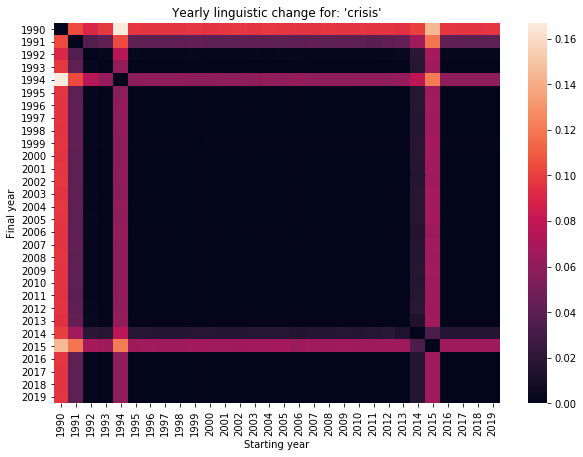

In [27]:
plot_divergence('crisis', data_comparedEmbeddings)

In [28]:
def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

data_wordDivergences = findMostDivergent(data_comparedEmbeddings)

Found 729 words to compare


In [29]:
# most divergence
data_wordDivergences[:20]

[('state', 18.300449281930923),
 ('unite', 17.992438949644566),
 ('nation', 14.835680544376373),
 ('president', 13.80653902888298),
 ('union', 12.515876442193985),
 ('news', 12.175233036279678),
 ('new', 11.469517663121223),
 ('iraq', 10.214055359363556),
 ('middle', 9.922540128231049),
 ('east', 9.310654044151306),
 ('force', 9.035454213619232),
 ('house', 8.815692812204361),
 ('department', 8.794910550117493),
 ('minister', 8.19817104935646),
 ('not', 8.074066758155823),
 ('have', 7.182254672050476),
 ('military', 7.107830822467804),
 ('world', 6.83979469537735),
 ('know', 6.689740359783173),
 ('today', 6.610923707485199)]

In [30]:
# least divergence
data_wordDivergences[-20:]

[('culture', 0.05394464731216431),
 ('christians', 0.05386543273925781),
 ('card', 0.053667545318603516),
 ('voice', 0.05357581377029419),
 ('huge', 0.05342775583267212),
 ('especially', 0.05321460962295532),
 ('host', 0.05266225337982178),
 ('deliver', 0.05212980508804321),
 ('keep', 0.05212146043777466),
 ('advocate', 0.051025390625),
 ('list', 0.05064654350280762),
 ('lock', 0.050411105155944824),
 ('document', 0.048519134521484375),
 ('safety', 0.04770559072494507),
 ('victim', 0.046665728092193604),
 ('criminal', 0.04655766487121582),
 ('freedom', 0.04589110612869263),
 ('expose', 0.044013381004333496),
 ('reality', 0.033497750759124756),
 ('lack', 0.03167712688446045)]

iraq


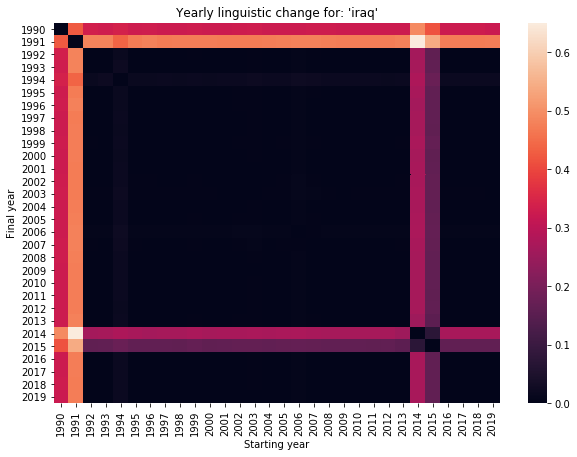

In [14]:
plot_divergence('iraq', data_comparedEmbeddings)

middle


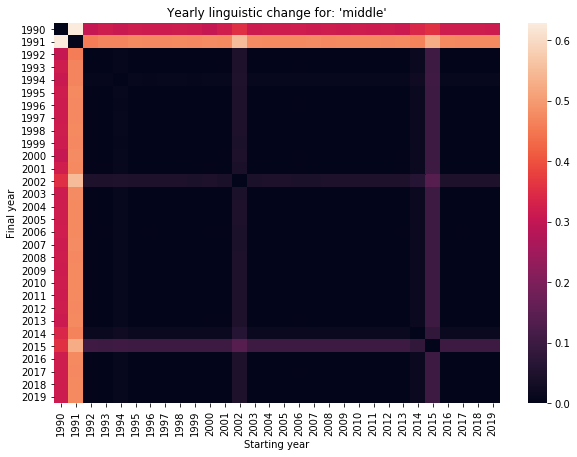

In [17]:
plot_divergence('middle', data_comparedEmbeddings)

east


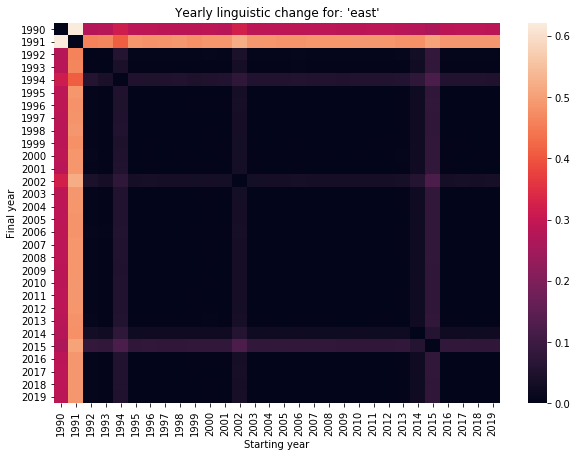

In [18]:
plot_divergence('east', data_comparedEmbeddings)

president


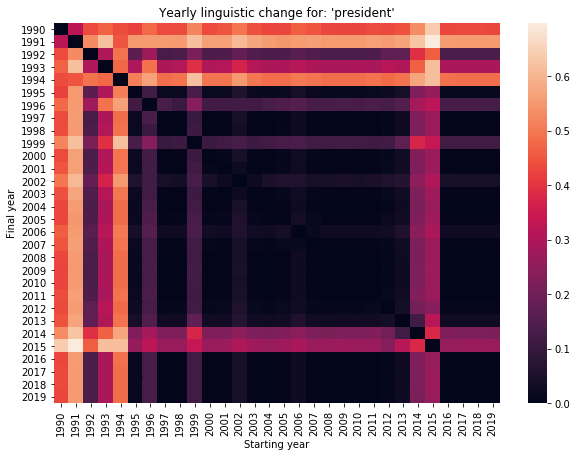

In [15]:
plot_divergence('president', data_comparedEmbeddings)